# Figure 3

In [35]:
import os
import scanpy as sc
import anndata as ad
import spatialdata
import spatialdata_plot
from pysankey import sankey # install via: pip install pysankeybeta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import scportrait
from sklearn.metrics import r2_score

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_hex

# Create a continuous colormap from defined colors
color_list =  ['#2F559A', '#5AADC5', '#F5DB12', '#E46425', '#B3262A']
custom_cmap = LinearSegmentedColormap.from_list('custom_gradient', color_list)

def generate_palette(n_colors, custom_cmap):
    palette = [custom_cmap(i / (n_colors - 1)) for i in range(n_colors)]

    # convert to hex colors 
    palette = [to_hex(x) for x in palette]
    return(palette)

color_list_blue = ['#FFFFFF','#2F559A']
custom_cmap_blue = LinearSegmentedColormap.from_list('custom_gradient', color_list_blue)


In [36]:
# define plotting parameters for consistency across figures and vector graphic export
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [37]:
anndata_file_all_results = '../figure_data/input_data_Xenium/xenium_ovarian_cancer_full.h5ad'
sdata_file_path = "../figure_data/input_data_Xenium/scportrait.sdata"
h5sc_path = '../figure_data/input_data_Xenium/single_cells.h5sc'
figures_directory = "../manuscript_figures/Figure_3/"
px_size = 0.2125 #µm
os.makedirs(figures_directory, exist_ok=True)

In [38]:
data = sc.read_h5ad(anndata_file_all_results)
h5sc = scportrait.io.read_h5sc(h5sc_path)
sdata = spatialdata.read_zarr(sdata_file_path)

version mismatch: detected: RasterFormatV02, requested: FormatV04
version mismatch: detected: RasterFormatV02, requested: FormatV04
version mismatch: detected: RasterFormatV02, requested: FormatV04
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Fig 3b SCimilarity Image Embeddings

In [39]:
# subset dataset to test set and non-tumor cells
test_data = data[data.obs['is_in_vitmae_test_set']].copy()
test_data = test_data[~test_data.obs['is_tumor_cell_type']].copy()

In [40]:
# calculate R2 score for all test set non-tumor cells
r2_single = r2_score(
    test_data.obsm['X_SCimilarity_transcriptome_embeds'].flatten(),
    test_data.obsm['X_SCimilarity_image_embeds'].flatten()
)
print("Overall R²:", r2_single)

Overall R²: 0.6489838361740112


In [41]:
# get the X_SCimilarity image embeddings for visualization
plot_data = ad.AnnData(
    X=data.obsm['X_SCimilarity_image_embeds'],
    obs=data.obs
)

# subest to test set and non-tumor cells
plot_data = plot_data[plot_data.obs['is_in_vitmae_test_set']]
plot_data = plot_data[~plot_data.obs['is_tumor_cell_type']].copy()

In [42]:
# using single-cell rapids to calculate TSNE and UMAP embeddings requires a CUDA-enabled Nvidia GPU
# check for Nvidia GPU and configure for use with GPU accelerated rapids single-cell
import torch
if torch.cuda.is_available():
    print("GPU is available. Proceeding with GPU-accelerated computations.")
    
    # import packages for GPU-accelerated analysis
    import rmm
    import cupy as cp
    import rapids_singlecell as rsc
    from cuml.manifold import TSNE
    
    from rmm.allocators.cupy import rmm_cupy_allocator

    # initialize RAPIDS memory manager
    rmm.reinitialize(
        pool_allocator=True,
        initial_pool_size=2 << 30,  # 2GB
        devices=list(map(int, os.environ.get("CUDA_VISIBLE_DEVICES").split(","))),
    )
    cp.cuda.set_allocator(rmm_cupy_allocator)

    # move data to GPU
    rsc.get.anndata_to_GPU(plot_data)
    
    # scale data
    rsc.pp.scale(plot_data)

    # calculate PCs
    rsc.pp.pca(plot_data, n_comps=100)

    # calculate tSNE embedding
    rsc.tl.tsne(
        plot_data,
        n_pcs=100,
        perplexity=30,
        early_exaggeration=12,
        learning_rate=200,
    )

    # save results to file for reloading
    np.save(f'../figure_data/input_data_Xenium/TestSet_Image_SCimilarity_embeddings_tsne_coords.npy', plot_data.obsm['X_tsne'])

else:
    print("GPU is not available. Skipping GPU-accelerated computations and loading precomputed results.")
    tsne_coordinates = np.load("../figure_data/input_data_Xenium/TestSet_Image_SCimilarity_embeddings_tsne_coords.npy")
    plot_data.obsm["X_tsne"] = tsne_coordinates

GPU is not available. Skipping GPU-accelerated computations and loading precomputed results.


In [43]:
plot_data.obs['SCimilarity_image_cell_type'].value_counts()

SCimilarity_image_cell_type
smooth muscle cell    2850
fibroblast            1470
endothelial cell      1048
macrophage             908
myofibroblast cell     715
epithelial cell        689
leukocyte              376
dendritic cell          11
monocyte                 3
Name: count, dtype: int64

In [44]:
# load predefined color palette
color_palette_path = "../figure_data/color_palettes/color_palette_image.pkl"
palette = pd.read_pickle(color_palette_path)

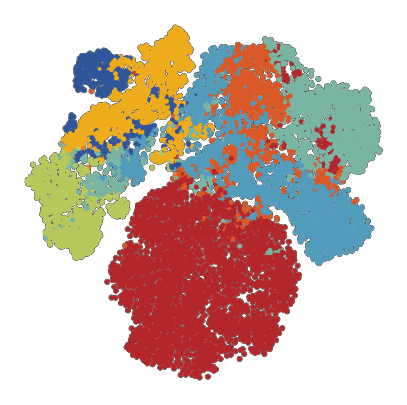

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.tsne(
    plot_data,
    color = 'SCimilarity_image_cell_type',
    palette=palette,
    ax = ax,
    s = 50,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    legend_loc=None,
    title='',
    na_color='white',
)
ax.set_aspect('equal')
fig.tight_layout()
fig.savefig(f'{figures_directory}/Fig_3c.png', dpi=600, bbox_inches='tight',)

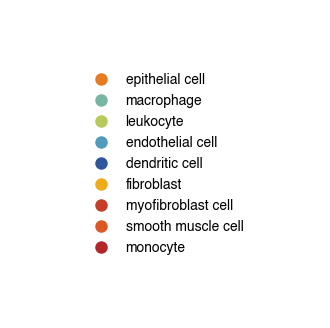

In [46]:
# Create figure containing the legend to the previously generated tSNE
df = pd.DataFrame({
    'SCimilarity_image_cell_type': plot_data.obs['SCimilarity_image_cell_type'].unique().tolist(),
    'color': plot_data.uns['SCimilarity_image_cell_type_colors'],
})

fig, ax = plt.subplots(figsize=(4, 4))
ax.axis("off")

# Build legend handles
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=row['color'], markersize=10,
               label=row['SCimilarity_image_cell_type'])
    for _, row in df.iterrows()
]
ax.legend(handles=handles, loc='center', frameon=False)
fig.savefig(f"{figures_directory}/Fig_3b_tSNE_legend.png", dpi=300, bbox_inches="tight")

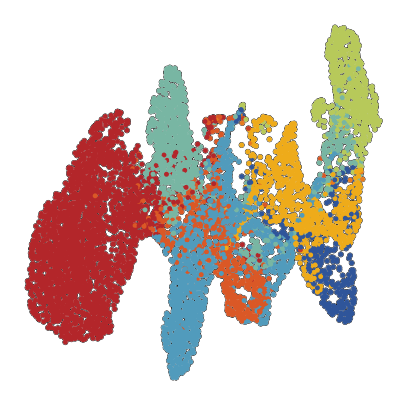

In [ ]:
# also visualize UMAP -> will only run if an Nvidia GPU is available
rsc.pp.neighbors(plot_data, use_rep='X')
rsc.tl.umap(plot_data)

fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(
    plot_data,
    color = 'SCimilarity_image_cell_type',
    palette=palette,
    ax = ax,
    s = 50,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    legend_loc=None,
    title='',
    na_color='white',
)
ax.set_aspect('equal')
fig.tight_layout()

## Fig 3c Prediction Error by Cell Type

In [47]:
predicted_scim = data.obsm['X_SCimilarity_image_embeds']
original_scim = data.obsm['X_SCimilarity_transcriptome_embeds']
prediction_mse = np.mean((predicted_scim - original_scim) ** 2, axis=1)

data.obs['Prediction_MSE'] = prediction_mse

In [48]:
# subset to test set and non-tumor cells for visualization
plot_data = data.obs[data.obs['is_in_vitmae_test_set']].copy()
plot_data = plot_data[~plot_data['is_tumor_cell_type']]

In [49]:
# read predefined color palette for visualization
color_palette_path = '../figure_data/color_palettes/color_palette_10X_celltype.pkl'
palette = pd.read_pickle(color_palette_path)

In [50]:
order = ["T and NK Cells",
         "Stromal Associated Fibroblasts",
         "Stromal Associated Endothelial Cells",
         "Fallopian Tube Epithelium",
         "Ciliated Epithelial Cells",
         "Unassigned",
         "Macrophages",
         "Pericytes",
         "Granulosa Cells",
         "Smooth Muscle Cells"
         ]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


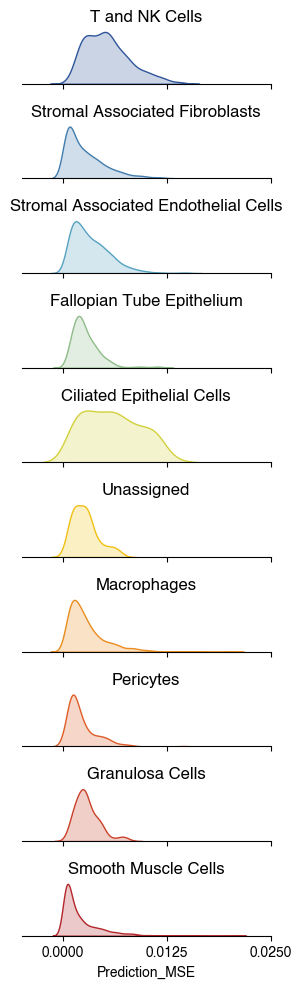

In [51]:
plot_data["10X_cell_type"] = pd.Categorical(plot_data["10X_cell_type"], categories=palette.keys(), ordered=True)
plot_data["10X_cell_type"] = plot_data["10X_cell_type"].cat.remove_unused_categories()

groups = plot_data.groupby("10X_cell_type", observed=False)
fig, axes = plt.subplots(len(groups), 1, figsize=(3, 1*len(groups)), sharex=True)

if len(groups) == 1:
    axes = [axes]

for ax, (name, group) in zip(axes, groups):
    color = palette.get(name, "#5aadc5")
    sns.kdeplot(data=group, x="Prediction_MSE", ax=ax, color=color, fill=True)
    ax.set_title(name)
    
    xlim = [-0.005,0.025]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_xticks([0, 0.0125, 0.025])
    
    ax.yaxis.set_visible(False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines["bottom"].set_visible(True)

plt.tight_layout()
plt.savefig(f'{figures_directory}/Fig_3d_MSE_per_celltype.pdf')

### example images for each 10X celltype

/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_74786/1368198002.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  select_cells = adata_plot.obs.groupby(["10X_cell_type"]).sample(n_cells, random_state = 42).get(["10X_cell_type", "scportrait_cell_id"])


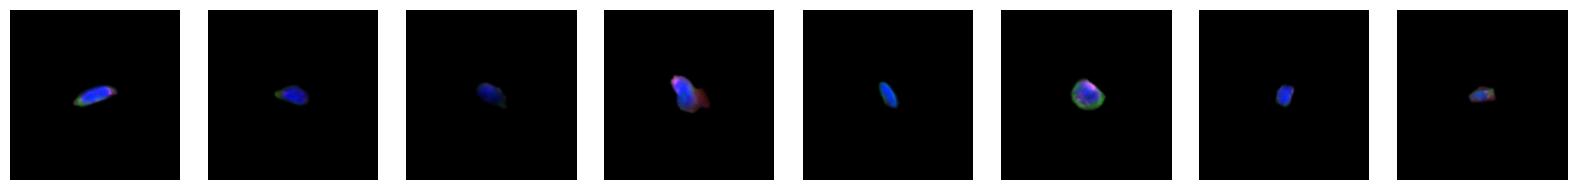

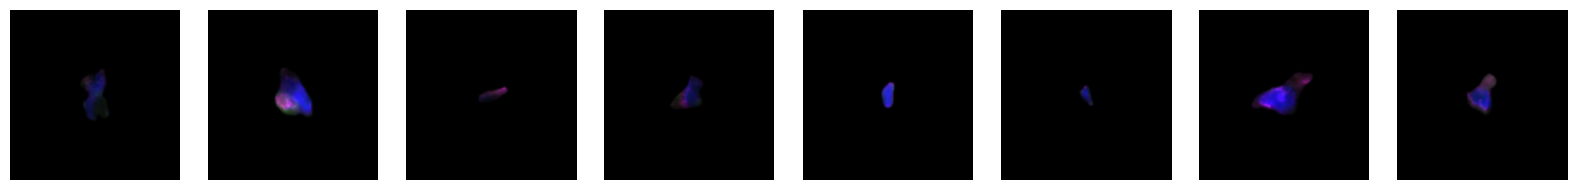

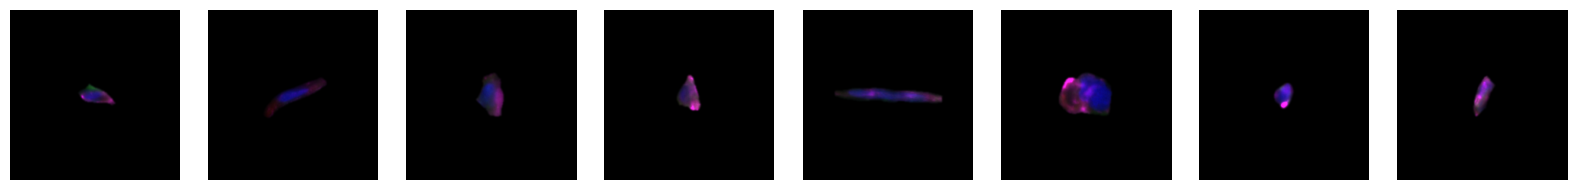

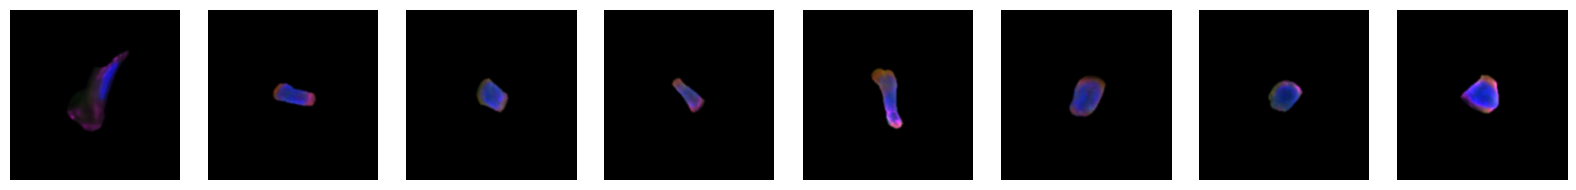

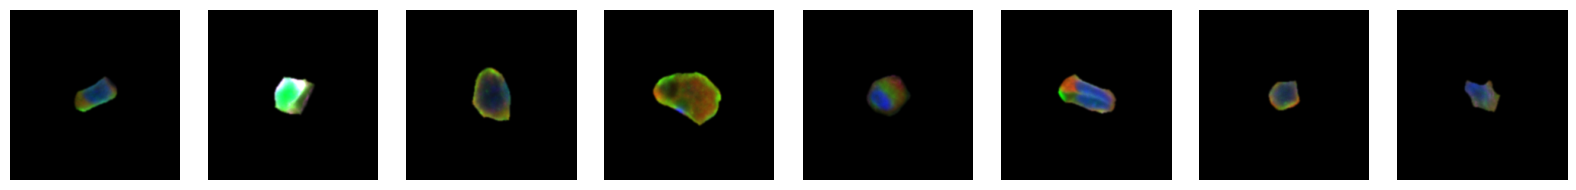

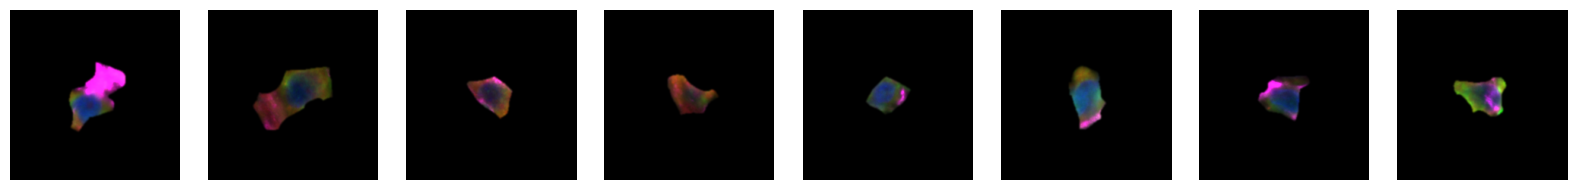

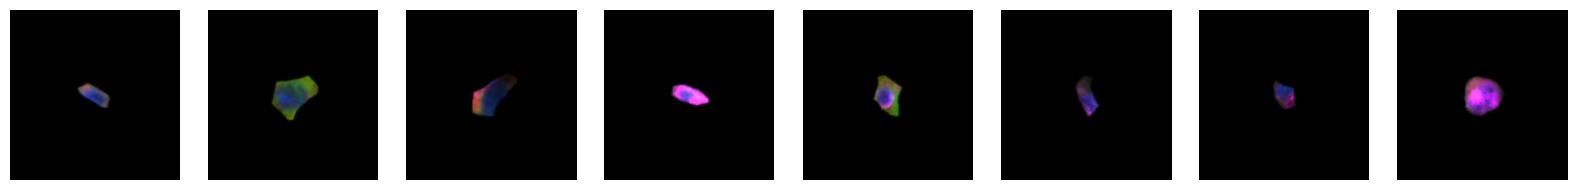

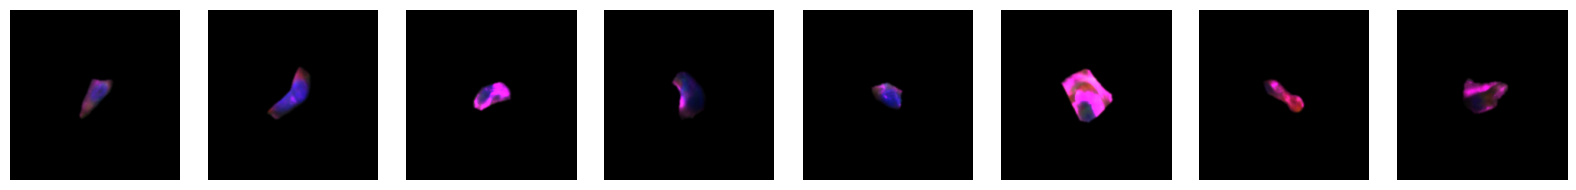

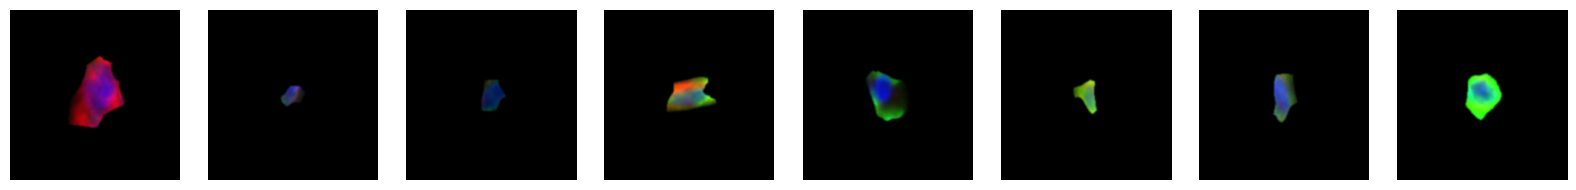

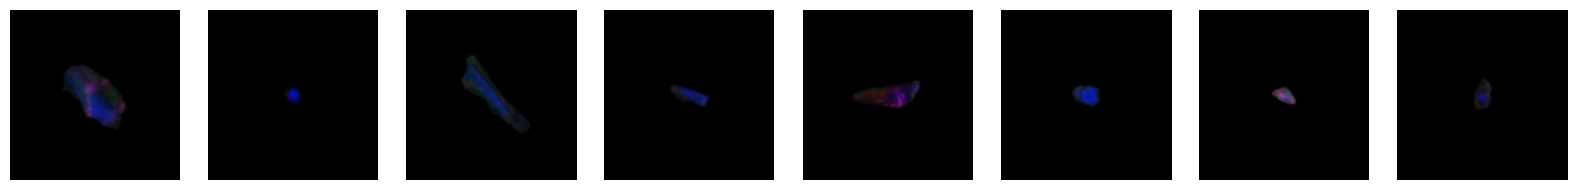

In [64]:
#load single cell images for visualization
adata_plot = sdata["table"]

n_cells = 8
single_cell_size = 2

select_cells = adata_plot.obs.groupby(["10X_cell_type"]).sample(n_cells, random_state = 42).get(["10X_cell_type", "scportrait_cell_id"])

for cell_type in order:
    cell_ids = select_cells[select_cells["10X_cell_type"] == cell_type].scportrait_cell_id.tolist()
    channels = [1, 2, 3, 4]
    images = scportrait.tl.h5sc.get_image_with_cellid(h5sc, cell_id = cell_ids, select_channel = channels)

    fig_height = n_cells * single_cell_size
    fig_width = 1 * single_cell_size

    fig, _ax = plt.subplots(1, n_cells, figsize=(fig_height, fig_width))
    for _i, img in enumerate(images):
        _ax[_i].imshow(scportrait.pl.vis.generate_composite(img))
        _ax[_i].axis("off")

    fig.tight_layout()
    fig.savefig(f"{figures_directory}/Fig_3c_single_cell_images_10X_cell_type_{cell_type}.pdf", bbox_inches = "tight")

## Fig 3d: Sankey plots to visualize cell type overlap 

In [53]:
no_tumor_adata = data[~data.obs["is_tumor_cell_type"]]
no_tumor_adata_test = no_tumor_adata[no_tumor_adata.obs.is_in_vitmae_test_set]
no_tumor_adata_test = no_tumor_adata_test[~no_tumor_adata_test.obs["10X_cell_type"].isna(), :]

columns = ["10X_cell_type", 'SCimilarity_transcriptome_cell_type', 'SCimilarity_image_cell_type']
df = no_tumor_adata_test.obs.get(columns)

In [54]:
cell_order_10x = [
    'T and NK Cells',
    'Stromal Associated Fibroblasts',
    'Stromal Associated Endothelial Cells',
    'Fallopian Tube Epithelium',
    'Ciliated Epithelial Cells',
    'Unassigned',
    'Macrophages',
    'Pericytes',
    'Granulosa Cells',
    'Smooth Muscle Cells',
 
]

cell_order_transcriptome = [
    'leukocyte',
    'stromal cell of ovary',
    'fibroblast', 
    'endothelial cell',
    'epithelial cell',
    'mast cell',
    'macrophage',
    'dendritic cell',
    'myofibroblast cell',
    'monocyte',
    'smooth muscle cell',
]

cell_order_image = [x for x in cell_order_transcriptome if x not in ['stromal cell of ovary', 'mast cell']]

cell_order_10x.reverse()
cell_order_transcriptome.reverse()
cell_order_image.reverse()

with open("../figure_data/color_palettes/color_palette_transcriptome.pkl", "rb") as f:
    color_palette_transcriptome = pickle.load(f)

with open("../figure_data/color_palettes/color_palette_image.pkl", "rb") as f:
    color_palette_image = pickle.load(f)

with open("../figure_data/color_palettes/color_palette_10X_celltype.pkl", "rb") as f:
    color_palette_10X = pickle.load(f)


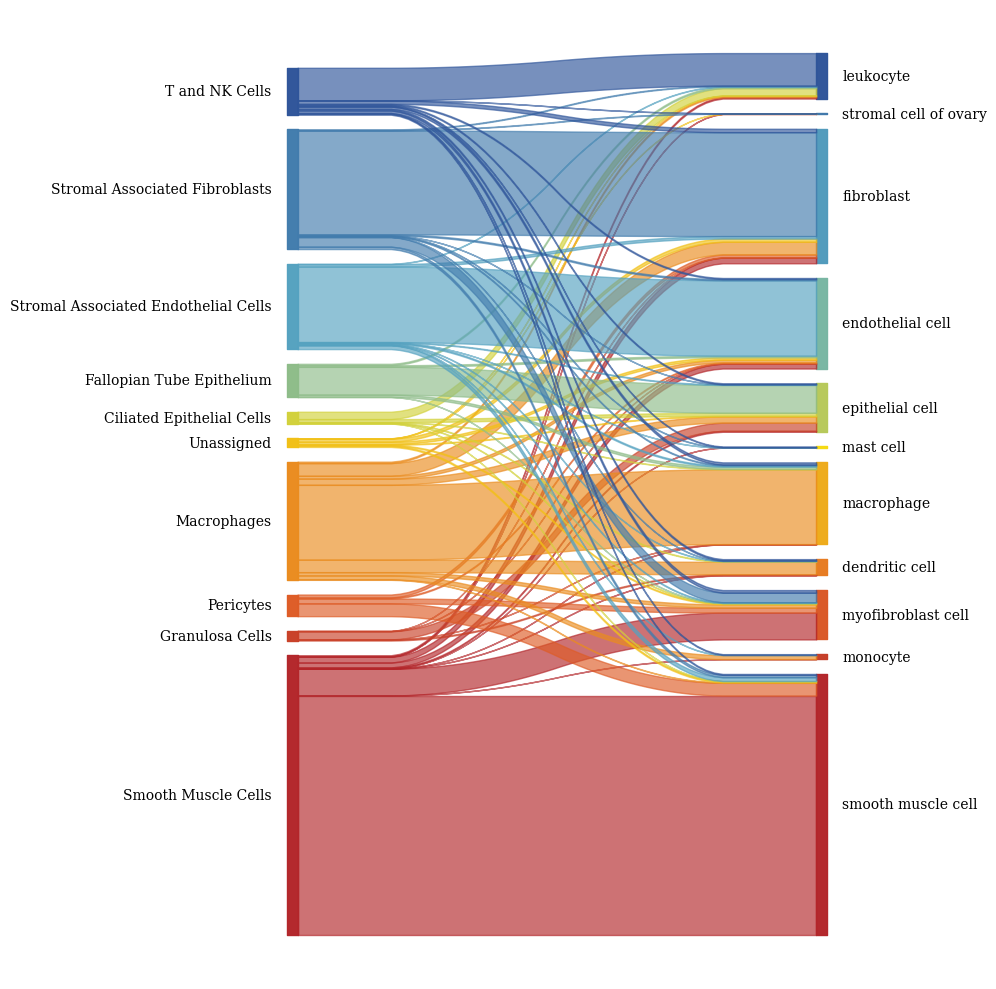

In [55]:
columns = ["10X_cell_type", 'SCimilarity_transcriptome_cell_type',]
color_palette = color_palette_10X | color_palette_transcriptome

# Create the sankey diagram
fig, axs = plt.subplots(1, 1, figsize = (10, 10))
sankey(
    left=df[columns[0]],
    right=df[columns[1]],
    leftLabels=cell_order_10x,
    rightLabels=cell_order_transcriptome,
    colorDict=color_palette,
    ax = axs,
    fontsize=10
)
fig.tight_layout()
fig.savefig(f"{figures_directory}/Fig_3d_left_panel.pdf", dpi = 300)

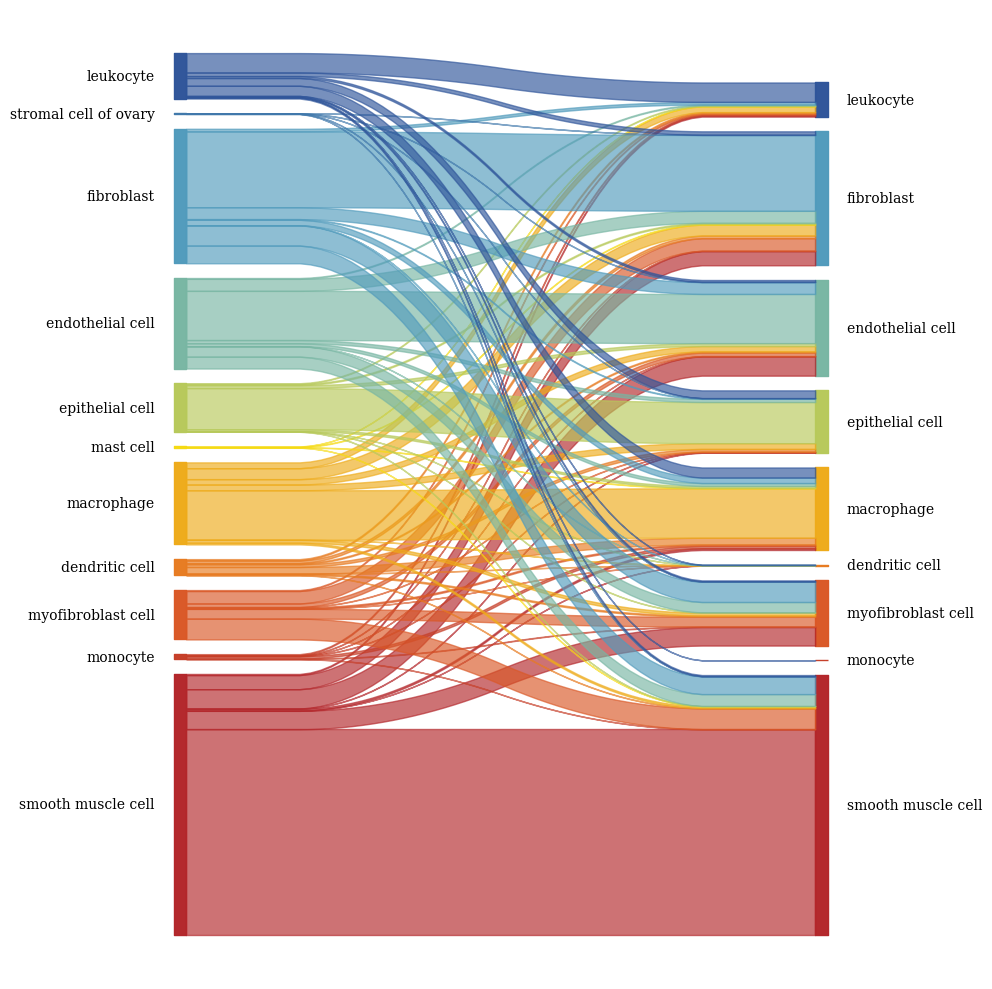

In [56]:
columns = ['SCimilarity_transcriptome_cell_type', 'SCimilarity_image_cell_type']
color_palette = color_palette_transcriptome | color_palette_image

# Create the sankey diagram
fig, axs = plt.subplots(1, 1, figsize = (10, 10))
sankey(
    left=df[columns[0]],
    right=df[columns[1]],
    leftLabels=cell_order_transcriptome,
    rightLabels=cell_order_image,
    colorDict=color_palette,
    ax = axs,
    fontsize=10
)
fig.tight_layout()
fig.savefig(f"{figures_directory}/Fig_3d_right_panel.pdf", dpi = 300)

## Fig 3e

In [57]:
missing_cols = [x for x in data.obs.columns if x not in sdata["table"].obs.columns]
annotation = data.obs[missing_cols + ["cell_id"]]
sdata["table"].obs = sdata["table"].obs.merge(annotation, on="cell_id", how = "outer")

# convert to category annotations
sdata["table"].obs["is_tumor_cell_type"] = sdata["table"].obs["is_tumor_cell_type"].astype("category")
sdata["table"].obs["is_in_vitmae_test_set"] = sdata["table"].obs["is_in_vitmae_test_set"].astype("category")
sdata["table"].obs["transcriptome_passed_QC"] = sdata["table"].obs["transcriptome_passed_QC"].astype("category")

In [58]:
# subset to designated test region for spatial visualization
center_x = 40300
center_y = 21650
max_width = 1500

sdata_select = scportrait.tl.sdata.processing.get_bounding_box_sdata(sdata, 
                                                                     center_x = center_x, 
                                                                     center_y = center_y, 
                                                                     max_width = max_width, 
                                                                     drop_points=False)

/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [59]:
for col in ["SCimilarity_transcriptome_cell_type", "SCimilarity_image_cell_type", "10X_cell_type"]:
    
    # Ensure column is categorical
    if not pd.api.types.is_categorical_dtype(sdata_select["table"].obs[col]):
        sdata_select["table"].obs[col] = sdata_select["table"].obs[col].astype("category")

    # Add 'tumor_cell_to_remove' category if missing
    if "tumor_cell_to_remove" not in sdata_select["table"].obs[col].cat.categories:
        sdata_select["table"].obs[col] = sdata_select["table"].obs[col].cat.add_categories("tumor_cell_to_remove")
    
    # Assign 'tumor_cell_to_remove' to tumor cells
    sdata_select["table"].obs.loc[sdata_select["table"].obs["is_tumor_cell_type"], col] = "tumor_cell_to_remove"

    # Clean up unused categories
    sdata_select["table"].obs[col] = sdata_select["table"].obs[col].cat.remove_unused_categories()

/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_74786/872542588.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(sdata_select["table"].obs[col]):
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_74786/872542588.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(sdata_select["table"].obs[col]):
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_74786/872542588.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(sdata_select["table"].obs[col]):


In [60]:
color_palette = {
    'SCimilarity_transcriptome_cell_type': {
                                            **color_palette_transcriptome,
                                            "tumor_cell_to_remove": "#ffffffff"
                                            },
    "10X_cell_type":  {
                    **color_palette_10X,
                    "tumor_cell_to_remove": "#ffffffff"
                    },
     'SCimilarity_image_cell_type':  {
                        **color_palette_image,
                        "tumor_cell_to_remove": "#ffffffff"
                        },
}

/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `seg_all_cytosol_vectorized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `_annotation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/utils.py:798: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_74786/2842461409.py:32: UserWarning: This figure includes Axes that are not com

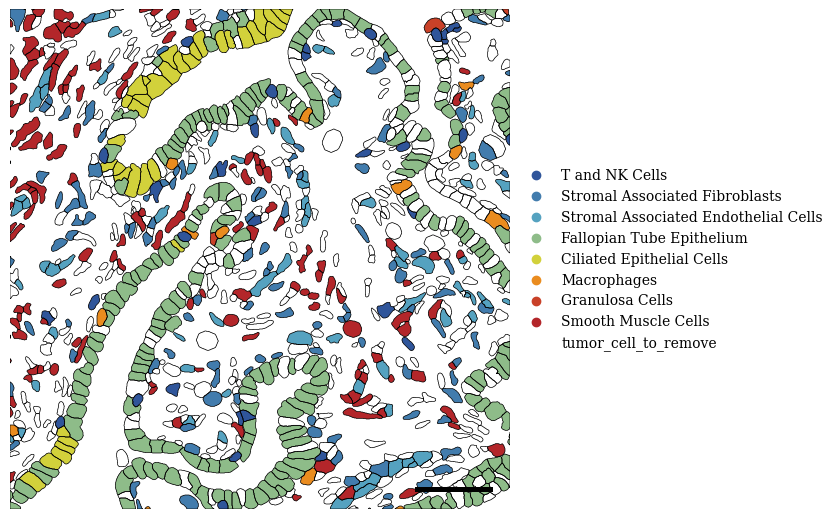

In [61]:
annotation = "10X_cell_type"

categories = sdata_select["table"].obs[annotation].unique()
groups = list(categories)
filtered_palette = {k: v for k, v in color_palette[annotation].items() if k in groups}

fig, axs = scportrait.pl.sdata._create_figure_dpi(1500, 1500, dpi = 300)
scportrait.pl.sdata.plot_labels(sdata_select, 
                                    label_layer= "seg_all_cytosol", 
                                    color = annotation, 
                                    palette = list(filtered_palette.values()),
                                    groups  = list(filtered_palette.keys()),
                                    vectorized = True,
                                    ax = axs,
                                    show_fig = False
                                    )

scportrait.pl.sdata.plot_segmentation_mask(sdata_select, 
                                            masks = ["seg_all_cytosol"], 
                                            background_image=None, 
                                            line_color = "black", 
                                            line_width=0.5, 
                                            show_fig = False,
                                            ax = axs)
scportrait.pl.add_scalebar(axs,
                            resolution = px_size, 
                            color = "black",  
                            border_pad = 1, 
                            fixed_length = 50, 
                            scale_loc = "none",
                            )
fig.tight_layout()
plt.show()
fig.savefig(f"{figures_directory}/Fig_3e_cell_labels_{annotation}.pdf", dpi = 300)

## Fig 3f

/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `seg_all_cytosol_vectorized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `_annotation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/utils.py:798: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_74786/3253037785.py:32: UserWarning: This figure includes Axes that are not com

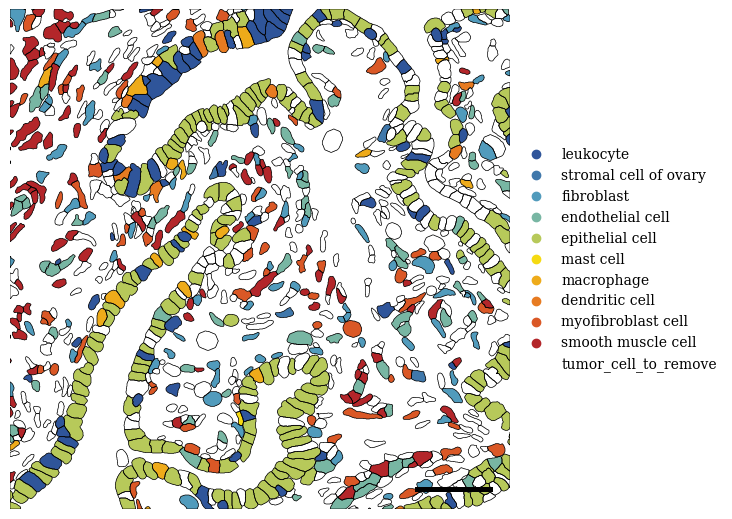

In [62]:
annotation = 'SCimilarity_transcriptome_cell_type'

categories = sdata_select["table"].obs[annotation].unique()
groups = list(categories)
filtered_palette = {k: v for k, v in color_palette[annotation].items() if k in groups}

fig, axs = scportrait.pl.sdata._create_figure_dpi(1500, 1500, dpi = 300)
scportrait.pl.sdata.plot_labels(sdata_select, 
                                    label_layer= "seg_all_cytosol", 
                                    color = annotation, 
                                    palette = list(filtered_palette.values()),
                                    groups  = list(filtered_palette.keys()),
                                    vectorized = True,
                                    ax = axs,
                                    show_fig = False
                                    )

scportrait.pl.sdata.plot_segmentation_mask(sdata_select, 
                                            masks = ["seg_all_cytosol"], 
                                            background_image=None, 
                                            line_color = "black", 
                                            line_width=0.5, 
                                            show_fig = False,
                                            ax = axs)
scportrait.pl.add_scalebar(axs,
                            resolution = px_size, 
                            color = "black",  
                            border_pad = 1, 
                            fixed_length = 50, 
                            scale_loc = "none",
                            )
fig.tight_layout()
plt.show()
fig.savefig(f"{figures_directory}/Fig_3e_cell_labels_{annotation}.pdf", dpi = 300)

## Fig 3g

/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `seg_all_cytosol_vectorized` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/mambaforge/envs/scPortrait/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `_annotation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/sophia/Documents/GitHub/spatialdata-plot/src/spatialdata_plot/pl/utils.py:798: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_74786/3845863371.py:32: UserWarning: This figure includes Axes that are not com

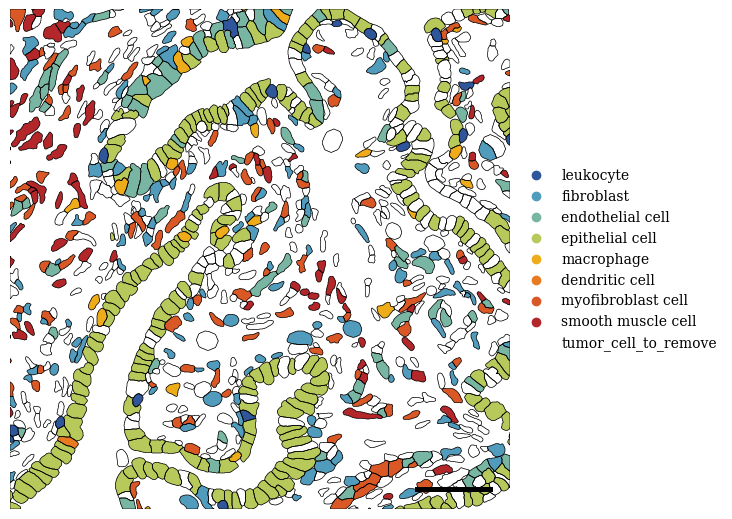

In [63]:
annotation = 'SCimilarity_image_cell_type'

categories = sdata_select["table"].obs[annotation].unique()
groups = list(categories)
filtered_palette = {k: v for k, v in color_palette[annotation].items() if k in groups}

fig, axs = scportrait.pl.sdata._create_figure_dpi(1500, 1500, dpi = 300)
scportrait.pl.sdata.plot_labels(sdata_select, 
                                    label_layer= "seg_all_cytosol", 
                                    color = annotation, 
                                    palette = list(filtered_palette.values()),
                                    groups  = list(filtered_palette.keys()),
                                    vectorized = True,
                                    ax = axs,
                                    show_fig = False
                                    )

scportrait.pl.sdata.plot_segmentation_mask(sdata_select, 
                                            masks = ["seg_all_cytosol"], 
                                            background_image=None, 
                                            line_color = "black", 
                                            line_width=0.5, 
                                            show_fig = False,
                                            ax = axs)
scportrait.pl.add_scalebar(axs,
                            resolution = px_size, 
                            color = "black",  
                            border_pad = 1, 
                            fixed_length = 50, 
                            scale_loc = "none",
                            )
fig.tight_layout()
plt.show()
fig.savefig(f"{figures_directory}/Fig_3e_cell_labels_{annotation}.pdf", dpi = 300)